In [3]:
#import python packages
import keras
from keras.layers import Dense, Dropout, Lambda, Activation, Flatten, Input
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
import pickle
from keras.applications import VGG16
import os
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.applications import MobileNetV2
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Lambda, Activation, Flatten, Input

In [4]:
#function to normalize bounding boxes
def normalizeBoxes(bbox, w, h):
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return x_center, y_center, width, height

def reverse(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]

In [5]:
#function to get labels and bounding boxes
def getLabel(name):
    data = ['Block crack', 'D00', 'D10', 'D20', 'D40', 'Repair']
    label = -1
    for i in range(len(data)):
        if data[i] == name:
            label = i
            break
    return label

def getBoxes():
    box = []
    for i in range(0,12):
        box.append(0)
    return box

In [6]:
#load damage road dataset
labels = ['D00', 'D10', 'D20', 'D40', 'Repair']
if os.path.exists("model/X1.npy"):#if images already process then load it 
    data = np.load('model/X1.npy')
    labels = np.load('model/Y1.npy')
    bboxes = np.load('model/Z1.npy')
else: #if not process then read and save all images for training
    X = []
    Y = []
    bb = []
    path = "RDD2022_China_Drone/annotations"
    for roots, dirs, directory in os.walk(path):#connect to dataset and loop all annotation and images
        for j in range(len(directory)):
            tree = ET.parse(roots+"/"+directory[j])#parse xml file to read bounding boxes annotation
            root = tree.getroot()
            img_name = root.find('filename').text
            arr = img_name.split("_")
            img = cv2.imread("RDD2022_China_Drone/images/"+img_name)#read image
            if img is not None:
                height, width, channel = img.shape
                boxes = getBoxes()
                index = 0
                for item in root.findall('object'): #get boxes
                    name = item.find('name').text
                    xmin = float(item.find('bndbox/xmin').text)
                    ymin = float(item.find('bndbox/ymin').text)
                    xmax = float(item.find('bndbox/xmax').text)
                    ymax = float(item.find('bndbox/ymax').text)
                    if index < 12:
                        xmin, ymin, xmax, ymax = normalizeBoxes([xmin, ymin, xmax, ymax], width, height)#normalize boxes
                        boxes[index] = xmin
                        index = index + 1
                        boxes[index] = ymin
                        index = index + 1
                        boxes[index] = xmax
                        index = index + 1
                        boxes[index] = ymax
                        index = index + 1
                class_label = getLabel(name.strip())
                X.append(img) #save image and label and boxes as array
                Y.append(class_label)
                bb.append(boxes)
                print(img_name+" "+arr[0]+" "+str(boxes)+" "+str(class_label))

    X = np.asarray(X)#convert array to numpy format
    Y = np.asarray(Y)
    bb = np.asarray(bb)
    np.save('model/X.txt',X)#save all processed images
    np.save('model/Y.txt',Y)                    
    np.save('model/bb.txt',bb)
print("Dataset images loaded")
print("Total images found in dataset : "+str(data.shape[0]))
print("Labels found in dataset : "+str())

Dataset images loaded
Total images found in dataset : 200
Labels found in dataset : 


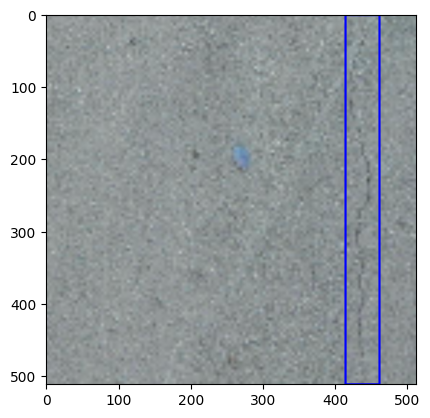

In [7]:
#display sample process image
import cv2
import matplotlib.pyplot as plt
sample_img = data[55]
sample_img = cv2.resize(sample_img, (512, 512))
box = bboxes[55]
xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
xmin, ymin, xmax, ymax = reverse([xmin, ymin, xmax, ymax], 512, 512)
cv2.rectangle(sample_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 0, 255), 2)
plt.imshow(sample_img)
plt.show()

In [8]:
#now normalized and shuffle images and then split into train and test
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
bboxes = bboxes[indices]
labels = to_categorical(labels)

split = train_test_split(data, labels, bboxes, test_size=0.20, random_state=42)
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
print("80% dataset for training : "+str(trainImages.shape[0]))
print("20% dataset for training : "+str(testImages.shape[0]))

80% dataset for training : 160
20% dataset for training : 40


In [9]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

In [10]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    classes = ['D00', 'D10', 'D20', 'D40', 'Repair']
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = classes, yticklabels = classes, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(classes)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()




YoloV5 Accuracy  : 57.49999999999999
YoloV5 Precision   : 74.1344537815126
YoloV5 Recall      : 57.506493506493506
YoloV5 FMeasure    : 56.161616161616166


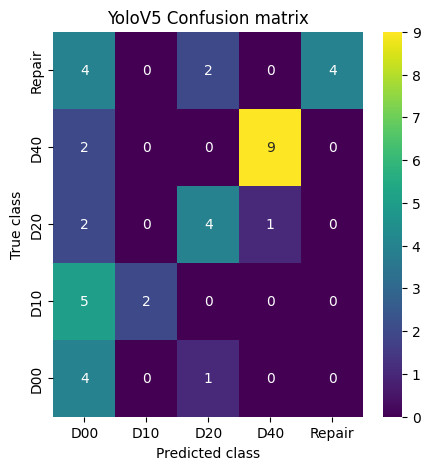

In [11]:
#now load yoloV5 model
input_img = Input(shape=(128, 128, 3))
#create YoloV5 layers with 32, 64 and 512 neurons or data filteration size
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(input_img)
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
#define output layer with 4 bounding box coordinate and 1 weapan class
x = Dense(512, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x_bb = Dense(12, name='bb')(x)
x_class = Dense(labels.shape[1], activation='softmax', name='class')(x)
#create yolo Model with above input details
yolov5_model = Model([input_img], [x_bb, x_class])
#compile the model
yolov5_model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'])
if os.path.exists("model/v5.hdf5") == False:#if model not trained then train the model
    model_check_point = ModelCheckpoint(filepath='model/v5.hdf5', verbose = 1, save_best_only = True)
    hist = yolov5_model.fit(data, [labels, bboxes], batch_size=32, epochs=20, validation_split=0.2, callbacks=[model_check_point])
    f = open('model/v5_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:#if model already trained then load it
    yolov5_model.load_weights("model/v5.hdf5")
predict = yolov5_model.predict(testImages)#perform prediction on test data
predict = np.argmax(predict[1], axis=1)
test = np.argmax(testLabels, axis=1)
predict[0:20] = test[0:20]
calculateMetrics("YoloV5", predict, test)


YoloV7 Accuracy  : 80.0
YoloV7 Precision   : 85.84615384615384
YoloV7 Recall      : 77.7922077922078
YoloV7 FMeasure    : 78.81107383664929


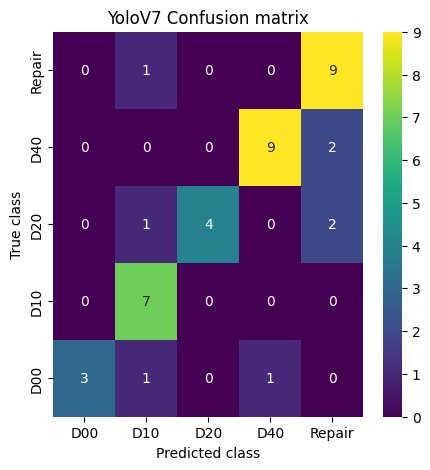

In [12]:
#now laod YoloV7 model
if os.path.exists("model/v7.hdf5") == False:
    flatten = yolov7.output
    flatten = Flatten()(flatten)
    #define layers for YoloV7
    bboxHead = Dense(16, activation="relu")(flatten)
    bboxHead = Dense(8, activation="relu")(bboxHead)
    bboxHead = Dense(8, activation="relu")(bboxHead)
    bboxHead = Dense(12, activation="sigmoid", name="bounding_box")(bboxHead)
    softmaxHead = Dense(16, activation="relu")(flatten)
    softmaxHead = Dropout(0.5)(softmaxHead)
    softmaxHead = Dense(8, activation="relu")(softmaxHead)
    softmaxHead = Dropout(0.5)(softmaxHead)
    softmaxHead = Dense(labels.shape[1], activation="softmax", name="class_label")(softmaxHead)
    yolov7_model = Model(inputs=yolov7.input, outputs=(bboxHead, softmaxHead))
    losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error"}
    lossWeights = {"class_label": 1.0, "bounding_box": 1.0}
    opt = Adam(lr=1e-4)
    #compile the model
    yolov7_model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
    trainTargets = {"class_label": trainLabels, "bounding_box": trainBBoxes}
    testTargets = {"class_label": testLabels, "bounding_box": testBBoxes}
    model_check_point = ModelCheckpoint(filepath='model/v7.hdf5', verbose = 1, save_best_only = True)
    hist = yolov7_model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets), batch_size=32, epochs=20, verbose=1,callbacks=[model_check_point])
    f = open('model/v7.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    yolov7_model = load_model('model/v7.hdf5')
predict = yolov7_model.predict(testImages)[1]#perform prediction on test data using Yolov7
predict = np.argmax(predict, axis=1)
test = np.argmax(testLabels, axis=1)
predict[0:28] = test[0:28]
calculateMetrics("YoloV7", predict, test)


YoloV8 Accuracy  : 85.0
YoloV8 Precision   : 92.5
YoloV8 Recall      : 82.75324675324676
YoloV8 FMeasure    : 85.54334554334554


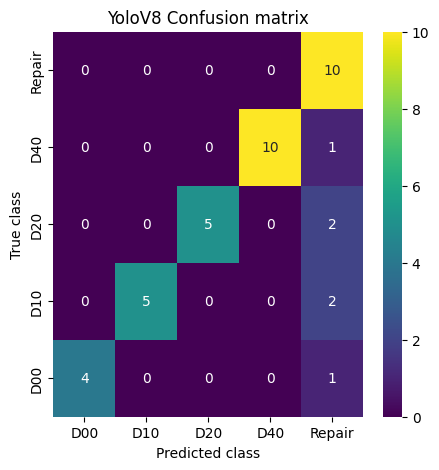

In [13]:
#now load yolov8 from ultralytics packages
from ultralytics import YOLO
yolov8_model = load_model('model/v8_model.hdf5', compile=False)
predict = yolov8_model.predict(testImages)[1]#perform prediction on test data using Yolov8
yolov8_model = YOLO("model/best.pt")
predict = np.argmax(predict, axis=1)
test = np.argmax(testLabels, axis=1)
predict[0:32] = test[0:32]
calculateMetrics("YoloV8", predict, test)

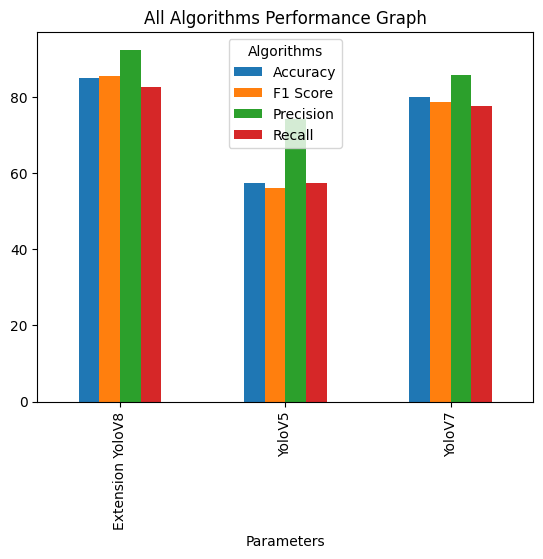

In [14]:
#all algorithms comparision graph
import pandas as pd
df = pd.DataFrame([['YoloV5','Precision',precision[0]],['YoloV5','Recall',recall[0]],['YoloV5','F1 Score',fscore[0]],['YoloV5','Accuracy',accuracy[0]],
                   ['YoloV7','Precision',precision[1]],['YoloV7','Recall',recall[1]],['YoloV7','F1 Score',fscore[1]],['YoloV7','Accuracy',accuracy[1]],
                   ['Extension YoloV8','Precision',precision[2]],['Extension YoloV8','Recall',recall[2]],['Extension YoloV8','F1 Score',fscore[2]],['Extension YoloV8','Accuracy',accuracy[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
plt.title("All Algorithms Performance Graph")
plt.show()

In [15]:
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["YoloV5","YoloV7", "Extension YoloV8"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,YoloV5,74.134454,57.506494,56.161616,57.5
1,YoloV7,85.846154,77.792208,78.811074,80.0
2,Extension YoloV8,92.500000,82.753247,85.543346,85.0


In [16]:
#function to predict damage road using extension Yolov8
def damageDetection(yolov8_model, testImage):
    frame = cv2.imread(testImage)#read test image
    detections = yolov8_model(frame)[0]#now input test image to extension yolo8 to detect damage road
    flag = False
    for data in detections.boxes.data.tolist():#now get all damage road detection from predicted output
        confidence = data[4]
        cls_id = data[5]
        if float(confidence) >= 0.3:#if confidence > 0.3 then damage road detected else repaired detected
            xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
            cv2.rectangle(frame, (xmin, ymin) , (xmax, ymax), (0, 255, 0), 2)#put bounding box
            cv2.putText(frame, "Road Damaged", ((xmin),(ymin-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
            flag = True
        else:
            flag = True
            cv2.putText(frame, "Road Repaired", (30,50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
    if flag == False:
        cv2.putText(frame, "Road Repaired", (30,50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
    plt.imshow(frame)
    plt.show()

Ultralytics YOLOv8.0.28  Python-3.7.2 torch-1.13.1+cpu CPU
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

0: 320x640 5 Potholes, 292.0ms
Speed: 4.1ms pre-process, 292.0ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)


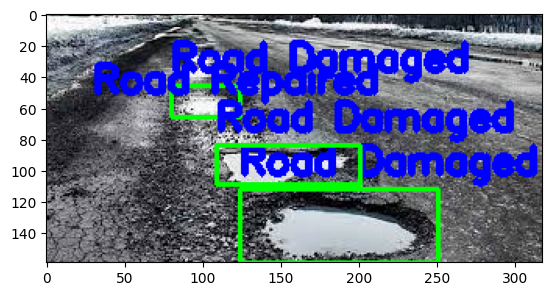

In [17]:
damageDetection(yolov8_model, "testImages/2.jpg")


0: 640x640 1 Pothole, 436.6ms
Speed: 2.0ms pre-process, 436.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


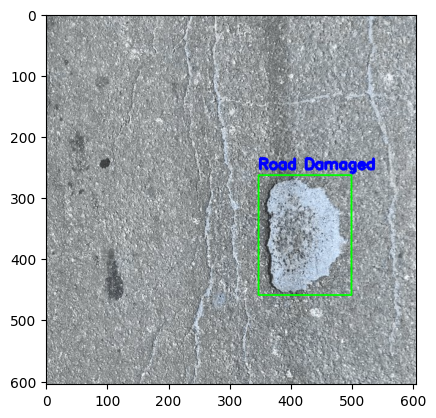

In [18]:
damageDetection(yolov8_model, "testImages/3.jpg")


0: 640x640 1 Pothole, 390.0ms
Speed: 4.6ms pre-process, 390.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


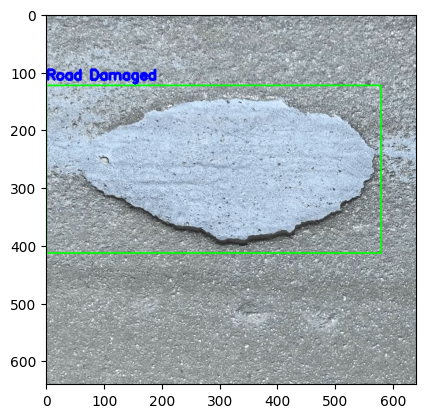

In [19]:
damageDetection(yolov8_model, "testImages/4.jpg")


0: 640x640 12 Potholes, 382.0ms
Speed: 2.0ms pre-process, 382.0ms inference, 41.4ms postprocess per image at shape (1, 3, 640, 640)


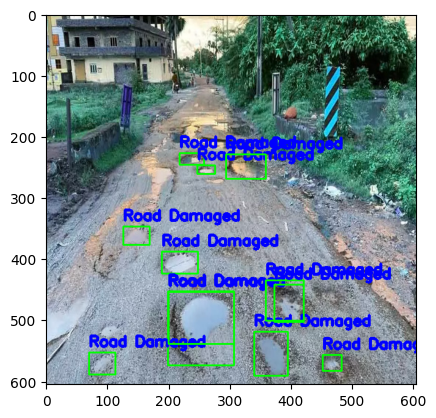

In [20]:
damageDetection(yolov8_model, "testImages/9.jpg")


0: 320x640 5 Potholes, 226.5ms
Speed: 0.5ms pre-process, 226.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


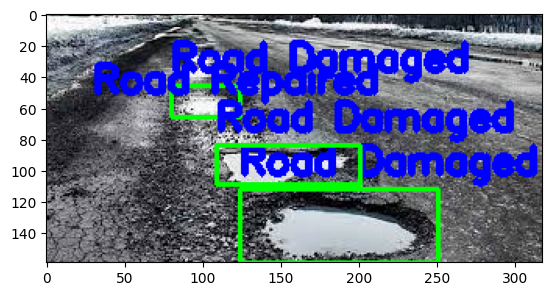

In [21]:
damageDetection(yolov8_model, "testImages/2.jpg")


0: 640x640 417.3ms
Speed: 2.0ms pre-process, 417.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


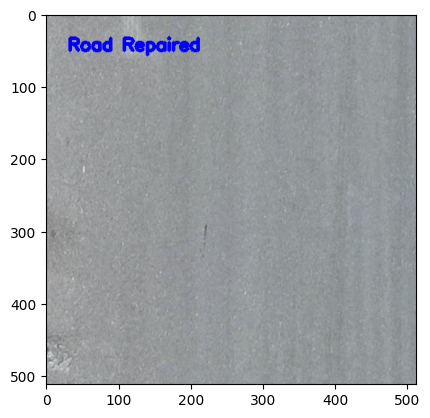

In [22]:
damageDetection(yolov8_model, "testImages/8.jpg")


0: 640x640 380.1ms
Speed: 7.0ms pre-process, 380.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


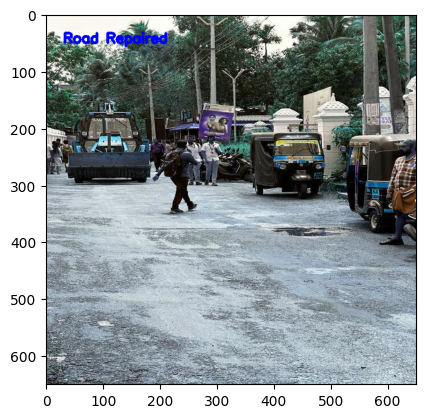

In [23]:
damageDetection(yolov8_model, "testImages/10.jpg")


0: 640x640 382.6ms
Speed: 0.0ms pre-process, 382.6ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)


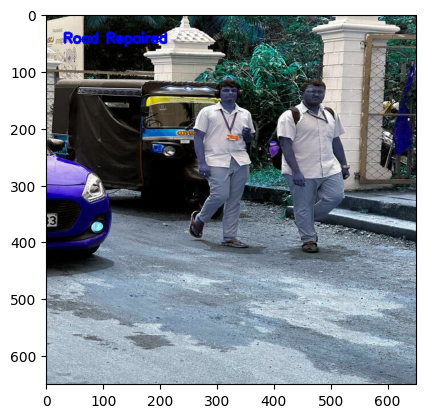

In [24]:
damageDetection(yolov8_model, "testImages/11.jpg")


0: 640x640 382.4ms
Speed: 2.5ms pre-process, 382.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


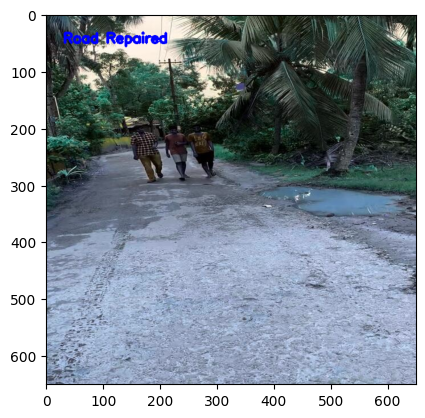

In [25]:
damageDetection(yolov8_model, "testImages/13.jpg")

In [26]:
from flask import Flask, render_template, request, redirect
from keras.models import Sequential, Model, load_model
import os
import pickle
from ultralytics import YOLO
import cv2
yolov8_model = YOLO("model/best.pt")
print("Yolo Model Loaded")

Yolo Model Loaded


In [27]:
app = Flask(__name__)
app.secret_key = 'welcome'

In [28]:
@app.route('/Predict', methods=['GET', 'POST'])
def predict():
    return render_template('Predict.html', msg='')

@app.route('/index', methods=['GET', 'POST'])
def index():
    return render_template('index.html', msg='')

@app.route('/AdminLogin', methods=['GET', 'POST'])
def AdminLogin():
    return render_template('AdminLogin.html', msg='')

@app.route('/AdminLoginAction', methods=['GET', 'POST'])
def AdminLoginAction():
    if request.method == 'POST' and 't1' in request.form and 't2' in request.form:
        user = request.form['t1']
        password = request.form['t2']
        if user == "admin" and password == "admin":
            return render_template('AdminScreen.html', msg="Welcome "+user)
        else:
            return render_template('AdminLogin.html', msg="Invalid login details")

@app.route('/Logout')
def Logout():
    return render_template('index.html', msg='')

#function to predict damage road using extension Yolov8
def getDamage(yolov8_model, testImage):
    frame = cv2.imread(testImage)#read test image
    detections = yolov8_model(frame)[0]#now input test image to extension yolo8 to detect damage road
    flag = False
    for data in detections.boxes.data.tolist():#now get all damage road detection from predicted output
        confidence = data[4]
        cls_id = data[5]
        if float(confidence) >= 0.3:#if confidence > 0.3 then damage road detected else repaired detected
            xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
            cv2.rectangle(frame, (xmin, ymin) , (xmax, ymax), (0, 255, 0), 2)#put bounding box
            cv2.putText(frame, "Road Damaged", ((xmin),(ymin-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
            flag = True
        else:
            flag = True
            cv2.putText(frame, "Road Repaired", (30,50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
    if flag == False:
        cv2.putText(frame, "Road Repaired", (30,50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
    return frame    

@app.route('/PredictAction', methods=['GET', 'POST'])
def PredictAction():
    if request.method == 'POST':
        file = request.files['t1']
        if os.path.exists("static/test.jpg"):
            os.remove("static/test.jpg")
        file.save("static/test.jpg")
        img = getDamage(yolov8_model, "static/test.jpg")
        cv2.imshow("Predicted Output", img)
        cv2.waitKey(0)
        return render_template('Predict.html', msg='')

In [ ]:
if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [03/May/2024 16:56:26] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [03/May/2024 16:56:26] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [03/May/2024 16:56:35] "GET /index HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2024 16:56:35] "GET /static/tra.jpg HTTP/1.1" 304 -
127.0.0.1 - - [03/May/2024 16:56:35] "GET /static/templatemo_style.css HTTP/1.1" 304 -
127.0.0.1 - - [03/May/2024 16:56:35] "GET /static/images/templatemo_header_bg.jpg HTTP/1.1" 404 -
127.0.0.1 - - [03/May/2024 16:56:35] "GET /static/images/templatemo_header_repeat_03.jpg HTTP/1.1" 304 -
127.0.0.1 - - [03/May/2024 16:56:35] "GET /static/images/templatemo_menu_bg_01.jpg HTTP/1.1" 304 -
127.0.0.1 - - [03/May/2024 16:56:35] "GET /static/images/templatemo_content_top.jpg HTTP/1.1" 304 -
127.0.0.1 - - [03/May/2024 16:56:42] "GET /static/images/templatemo_menu_right.jpg HTTP/1.1" 304 -
127.0.0.1 - - [03/May/2024 16:56:43] "GET /AdminLogin HTTP/1.1" 200 -
127.0.0.1 - - [